In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
# This is necessary only when running the notebook in the docker container
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']
/home/jovyan/fourier_learning_ibm


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import networkx as nx
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as Sampler,
    Batch,
)
from heisenberg import (
    HeisenbergModel,
    get_graph,
    get_positions,
)
from qiskit_aer import AerSimulator
from qiskit_aer.quantum_info import AerDensityMatrix
from qiskit_aer.noise import (
    NoiseModel,
    thermal_relaxation_error,
    depolarizing_error,
    pauli_error,
)
from qiskit.quantum_info.operators import Operator
from qiskit.primitives import BackendSamplerV2
from qiskit.quantum_info import (
    Statevector,
    state_fidelity,
    DensityMatrix,
    random_statevector,
)
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector
import json

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
# noise_thermal = NoiseModel()
# # error_gate1 = thermal_relaxation_error(161.83e3, 61.64e3, 368)
# p_gate1 = 0.05
# error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
# error_gate2 = error_gate1.tensor(error_gate1)
# noise_thermal.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
# noise_thermal.add_all_qubit_quantum_error(error_gate2, ["cx"])
# print(noise_thermal)

# backend_sim_noisy = AerSimulator(noise_model=noise_thermal)

In [6]:
noise_depola = NoiseModel()
noise_depola.add_all_qubit_quantum_error(depolarizing_error(0.01, 2), ["cx"])

backend_sim_noisy = AerSimulator(noise_model=noise_depola)

In [17]:
n_qubits = 3
n_iter = 1000

circ = QuantumCircuit(n_qubits)
for _ in range(n_iter):
    for i in range(n_qubits):
        circ.cx(i, (i + 1) % n_qubits)
circ.save_density_matrix()
# circ.draw("mpl")

In [18]:
result = backend_sim_noisy.run(circ).result()

In [19]:
state = result.data()["density_matrix"]
print(state)

DensityMatrix([[0.125+0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
                0.   +0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.125+0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
                0.   +0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.125+0.j, 0.   +0.j, 0.   +0.j,
                0.   +0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.125+0.j, 0.   +0.j,
                0.   +0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.125+0.j,
                0.   +0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
                0.125+0.j, 0.   +0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
                0.   +0.j, 0.125+0.j, 0.   +0.j],
               [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
                0.   +0.j, 0.   +0.j, 0.125+0.j]],
              dims=(2, 2, 2))


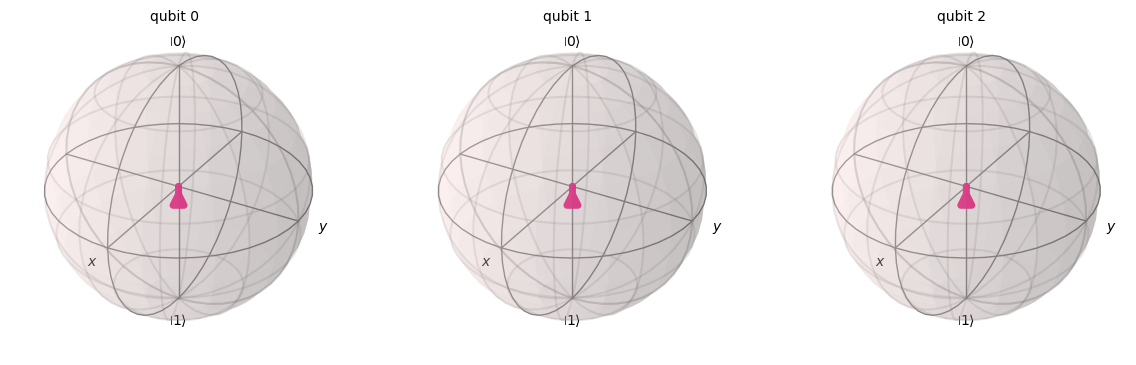

In [20]:
display(plot_bloch_multivector(state))

In [21]:
# completely mixed state
identity = np.eye(2**n_qubits)
completely_mixed_state = identity / 2**n_qubits

print(state_fidelity(state, completely_mixed_state))

1.0000000000004863


In [22]:
# Random state
random_state = random_statevector(2**n_qubits)

print(state_fidelity(state, random_state))

0.1249999999995623
